# Notebook to study investment records

This notebook analyze the different investments given in an excel file. Here, ``pandas`` library is used to explore the information stored in the excel file. At the end, it will be computed the TAE (using the XIRR), which give us an idea of the Extended Internal Rate of Return of non-periodic investments.

## Installing needed packages

In [1]:
pip install openpyxl numpy-financial pyxirr

Note: you may need to restart the kernel to use updated packages.


### Loading needed libraries

The following line load the relevant libraries in python to be used in this analysis.

In [2]:
# Loading the data
import pandas as pd
import numpy as np
import numpy_financial as npf
import pyxirr
from datetime import date
import matplotlib.pyplot as plt

## Reading the data file

Modify the following line to load the file with the investment records downloaded from etoro: 

In [3]:
# Read the excel file with the especific sheet (use the sheet_name option when the excel has multiple sheets)
df = pd.read_excel("../etoro-account-statement-example.xlsx", sheet_name = "Actividad de la cuenta")

# Take a look to the first rows of the dataframe
df.head()

,Fecha,Tipo,Detalles,Importe,Unidades,Cambio de capital realizado,Capital realizado,Saldo,ID de posición,Tipo de activo,Importe no retirable
0,05/01/2025 03:41:11,Depósito,200.00 USD CreditCard,200.0,-,200.0,200.0,200.0,-,-,0
1,06/01/2025 14:30:45,Posición abierta,VB/USD,37.5,0.152811,0.0,200.0,162.5,-,ETF,0
2,06/01/2025 14:30:52,Posición abierta,VOO/USD,112.5,0.205258,0.0,200.0,50.0,-,ETF,0
3,06/01/2025 14:31:32,Posición abierta,VXUS/USD,50.0,0.83738,0.0,200.0,0.0,-,ETF,0
4,22/01/2025 21:57:34,Depósito,200.00 USD CreditCard,200.0,-,200.0,400.0,200.0,-,-,0


In [4]:
# Run this line to list the name of the columns and the type of each variable in these columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Fecha                        92 non-null     object 
 1   Tipo                         92 non-null     object 
 2   Detalles                     92 non-null     object 
 3   Importe                      92 non-null     float64
 4   Unidades                     92 non-null     object 
 5   Cambio de capital realizado  92 non-null     float64
 6   Capital realizado            92 non-null     float64
 7   Saldo                        92 non-null     float64
 8   ID de posición               92 non-null     object 
 9   Tipo de activo               92 non-null     object 
 10  Importe no retirable         92 non-null     int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 8.0+ KB


In [5]:
# Show the lists of ETFs actions in the dataframe
df[df["Tipo"] == "Posición abierta"]["Detalles"].value_counts()

Detalles
VB/USD      10
VXUS/USD    10
VOO/USD      9
SPYG/USD     1
Name: count, dtype: int64

From the line above, it can be seen the list of ETFs in the dataframe. In the following code line, add a current price for each ETF (google it) and define the current date of your analysis:

In [6]:
# Search on internet the current prices of the VOO, VXUS, VB and SPYG (and any other additionall ETFs) listed in the df. If there 
# are more ETFs or actions, please include their prices here too.
current_price_VOO = 600.51
current_price_VXUS = 72.17
current_price_VB = 248.10
current_price_SPYG = 102.40

# Set the current date to compute the total TAE
current_date = pd.to_datetime("11/10/2025 00:00:00", format="%d/%m/%Y %H:%M:%S")

From the information given in the main dataframe, we only need the Date (Fecha), Type (Tipo), Details (Detalles), Imports (Importes) and Units (Unidades) to evaluate the main aspects of the investments.

In [7]:
# Define the relevant columns to keep in the analysis
relevant_columns = ['Fecha', 'Tipo', 'Detalles', 'Importe', 'Unidades']

# Create a dataframe called invests_df, where we will save the information with the relevant information.
invests_df = df[relevant_columns].copy()

# Set the Date column in a datatime format
invests_df["Fecha"] = pd.to_datetime(invests_df["Fecha"], format="%d/%m/%Y %H:%M:%S")

# Verify that the new dataframe contains only the relevant information and that the Date is given in datatime format
invests_df.info()

# Show the first rows of the invests_df
invests_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     92 non-null     datetime64[ns]
 1   Tipo      92 non-null     object        
 2   Detalles  92 non-null     object        
 3   Importe   92 non-null     float64       
 4   Unidades  92 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 3.7+ KB


,Fecha,Tipo,Detalles,Importe,Unidades
0,2025-01-05 03:41:11,Depósito,200.00 USD CreditCard,200.0,-
1,2025-01-06 14:30:45,Posición abierta,VB/USD,37.5,0.152811
2,2025-01-06 14:30:52,Posición abierta,VOO/USD,112.5,0.205258
3,2025-01-06 14:31:32,Posición abierta,VXUS/USD,50.0,0.83738
4,2025-01-22 21:57:34,Depósito,200.00 USD CreditCard,200.0,-


As we can see, the Tipo (type) column contains a description of the product in the dataframe. We can list the values in this type column and see which are the most relevant:

In [8]:
# List the kind of product/type of transactional movement.
invests_df["Tipo"].value_counts()

Tipo
Dividendo           55
Posición abierta    30
Depósito             7
Name: count, dtype: int64

As we can see, we have three types of products:
- **Dividends (Dividendos):** These are the dividens paid by each ETF. A dividend can be seen as a price paid by an ETF for each unit bought by the investor. These dividends tends to be low-price, but these are periodic. 
- **Open Position (Posición abierta):** These show us the units bought for each ETF. The number of units depends on the import spent for each ETF and their market prices at that date.
- **Deposit (Depósito):** This show us the records of payments to the portafolium. These are payments made in order to buy units in the market stock, and it is done through bank accounts or credit/debit cards by the investor. 

Now, lets see a general information by grouping them by variable. This can be done by using the ``groupby()`` function (to group our df by a given column values) and the ``describe()`` method to compute some numerical general information for a column (such as the mean, the standard deviation, the min and max values in the column, etc).

In [9]:
# Lets see the general info of the imports column by grouping the type column values
invests_df.groupby("Tipo")["Importe"].describe()

,count,mean,std,min,25%,50%,75%,max
Tipo,,,,,,,,
Depósito,7.0,286.857143,108.393463,200.00,200.0,200.0,399.00,410.00
Dividendo,55.0,0.182545,0.078415,0.08,0.1,0.2,0.25,0.30
Posición abierta,30.0,67.104333,33.942869,37.12,37.5,50.0,112.50,123.58


Now, we are going to consider only the information of the open positions (the units bought for each ETF):

In [10]:
# We create a df called actions_df with the Open positions (Position abierta) information
actions_df = invests_df[invests_df["Tipo"] == "Posición abierta"].copy()

# Show the first 5 rows of the actions_df
actions_df.head(5)

,Fecha,Tipo,Detalles,Importe,Unidades
1,2025-01-06 14:30:45,Posición abierta,VB/USD,37.5,0.152811
2,2025-01-06 14:30:52,Posición abierta,VOO/USD,112.5,0.205258
3,2025-01-06 14:31:32,Posición abierta,VXUS/USD,50.0,0.83738
5,2025-01-27 14:30:21,Posición abierta,VB/USD,37.5,0.150096
6,2025-01-27 14:32:42,Posición abierta,VOO/USD,112.5,0.204761


In [11]:
# We can compute the total imports made by the investor grouped by ETF product. The Details (Detalles) column provides
# the list of ETFs. The imports are given in USDs
actions_df.groupby("Detalles")["Importe"].sum()

Detalles
SPYG/USD     112.50
VB/USD       374.62
VOO/USD     1023.91
VXUS/USD     502.10
Name: Importe, dtype: float64

In [12]:
# It is also possible to compute the total imports by computing the sum of each individual import values
total_invest = actions_df["Importe"].sum()
print(f"Total invest value {total_invest} USDs")

Total invest value 2013.13 USDs


### Defying relevant functions

Now, we can define some functions that can be used later

In [13]:
# Function to compute the current price of an action in the market stocks. It receives the details to know what is the 
# ETF product, and the units to know how many units were bought.
def current_market_unit(details_column, units_column):
    current_value_unit = 0
    if(details_column == "VOO/USD"):
        current_value_unit = units_column*current_price_VOO
    elif(details_column == "VB/USD"):
        current_value_unit = units_column*current_price_VB
    elif(details_column == "VXUS/USD"):
        current_value_unit = units_column*current_price_VXUS
    elif(details_column == "SPYG/USD"):
        current_value_unit = units_column*current_price_SPYG
    else:
        current_value_unit = 0
    return current_value_unit

# Function to compute the TAE of a single investment up to the current date
def individual_TAE(inversion_date, acumulate):
    TAE = 0
    days = pd.Timedelta(current_date-inversion_date, unit="d").days
    TAE = (1+acumulate)**(1*(365/days))-1
    return TAE

## Cleaning and formating the data to be used

The following code line is a formatting of the needed variables. It is also created some new variables to be analyzed:

In [14]:
# It is formatted the Units to be float type.
actions_df["Unidades"] = actions_df["Unidades"].astype(float)

# It is computed the value of the ETF unit at the moment of the purchase
actions_df["Valor Liquidativo"] = actions_df["Importe"]/actions_df["Unidades"]

# Computing the current price of the units
actions_df["Valor del Mercado"] = np.vectorize(current_market_unit)(actions_df["Detalles"], actions_df["Unidades"]) 

# Computing the gain/lost of each investment
actions_df["Plusvalía/Minusvalía"] = actions_df["Valor del Mercado"] - actions_df["Importe"]

# Acumulative rate of each investment
actions_df["Acumulada"] = actions_df["Plusvalía/Minusvalía"] / actions_df["Importe"]

# Percentage of Acumulative rate of each investment
actions_df["% Acumulada"] = 100*actions_df["Acumulada"]

# Computing the current TAE (XIRR) of each investment up to date
actions_df["TAE"] = np.vectorize(individual_TAE)(actions_df["Fecha"], actions_df["Acumulada"])

# Percentage of XIRR for each investment up to the date
actions_df["% TAE"] = 100*actions_df["TAE"]

# Show the first 5 rows of the actions_df with the new columns
actions_df.head(5)

,Fecha,Tipo,Detalles,Importe,Unidades,Valor Liquidativo,Valor del Mercado,Plusvalía/Minusvalía,Acumulada,% Acumulada,TAE,% TAE
1,2025-01-06 14:30:45,Posición abierta,VB/USD,37.5,0.152811,245.401182,37.912409,0.412409,0.010998,1.099758,0.014517,1.451664
2,2025-01-06 14:30:52,Posición abierta,VOO/USD,112.5,0.205258,548.090696,123.259482,10.759482,0.095640,9.563984,0.127898,12.789810
3,2025-01-06 14:31:32,Posición abierta,VXUS/USD,50.0,0.837380,59.710048,60.433715,10.433715,0.208674,20.867429,0.283684,28.368387
5,2025-01-27 14:30:21,Posición abierta,VB/USD,37.5,0.150096,249.840102,37.238818,-0.261182,-0.006965,-0.696486,-0.009916,-0.991563
6,2025-01-27 14:32:42,Posición abierta,VOO/USD,112.5,0.204761,549.421032,122.961028,10.461028,0.092987,9.298692,0.135158,13.515846


In [15]:
# Run this line to see the columns and their type format in the actions_df
actions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 1 to 72
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Fecha                 30 non-null     datetime64[ns]
 1   Tipo                  30 non-null     object        
 2   Detalles              30 non-null     object        
 3   Importe               30 non-null     float64       
 4   Unidades              30 non-null     float64       
 5   Valor Liquidativo     30 non-null     float64       
 6   Valor del Mercado     30 non-null     float64       
 7   Plusvalía/Minusvalía  30 non-null     float64       
 8   Acumulada             30 non-null     float64       
 9   % Acumulada           30 non-null     float64       
 10  TAE                   30 non-null     float64       
 11  % TAE                 30 non-null     float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 3.0+ KB


In [16]:
# We can also print a general information by ETF of the % Acumulative gains/loss 
actions_df.groupby("Detalles")["% Acumulada"].describe()

,count,mean,std,min,25%,50%,75%,max
Detalles,,,,,,,,
SPYG/USD,1.0,-2.735565,NaN,-2.735565,-2.735565,-2.735565,-2.735565,-2.735565
VB/USD,10.0,3.958589,6.304430,-4.157316,-0.441605,2.280383,7.370381,15.836898
VOO/USD,9.0,9.583971,6.021811,1.357014,5.935836,9.563984,11.446649,19.549500
VXUS/USD,10.0,9.626092,8.039177,-1.903072,3.565402,10.419956,15.055038,20.867429


In [17]:
# Or print a general information by ETF of the gain/loss in USDs up to the current date
actions_df.groupby("Detalles")["Plusvalía/Minusvalía"].sum()

Detalles
SPYG/USD    -3.077510
VB/USD      14.825547
VOO/USD     99.259884
VXUS/USD    48.198343
Name: Plusvalía/Minusvalía, dtype: float64

In [18]:
# The total gain/loss of all the investments can be also computed by making the sum of all individual gains/loss 
# for each purchase
total_gain_loss = actions_df["Plusvalía/Minusvalía"].sum()
print(f"The total gain/loss of all the investments is: {total_gain_loss:.4f} USDs")

The total gain/loss of all the investments is: 159.2063 USDs


## Computing the TAE (XIRR)

Now that we have the needed variables, we can compute the TAE (XIRR) of all the investments.

In [19]:
# Compute the total current values of the purchases of each ETF
total_value_VOO = actions_df[actions_df["Detalles"]=="VOO/USD"]["Valor del Mercado"].sum()
total_value_VB = actions_df[actions_df["Detalles"]=="VB/USD"]["Valor del Mercado"].sum()
total_value_VXUS = actions_df[actions_df["Detalles"]=="VXUS/USD"]["Valor del Mercado"].sum()
total_value_SPYG = actions_df[actions_df["Detalles"]=="SPYG/USD"]["Valor del Mercado"].sum()
total_value_ETFs = actions_df["Valor del Mercado"].sum()

# Print the current value of each ETF in the portafolium
print(f"Total value of SPYG ETF in the portafolium: {total_value_SPYG:.4f} USDs")
print(f"Total value of VB ETF in the portafolium: {total_value_VB:.4f} USDs")
print(f"Total value of VOO ETF in the portafolium: {total_value_VOO:.4f} USDs")
print(f"Total value of VXUS ETF in the portafolium: {total_value_VXUS:.4f} USDs")

# Print the total value of the portafolium
print(f"Total value ETFs in the portafolium: {total_value_ETFs:.4f} USDs")

actions_df.groupby("Detalles")["Valor del Mercado"].sum()

Total value of SPYG ETF in the portafolium: 109.4225 USDs
Total value of VB ETF in the portafolium: 389.4455 USDs
Total value of VOO ETF in the portafolium: 1123.1699 USDs
Total value of VXUS ETF in the portafolium: 550.2983 USDs
Total value ETFs in the portafolium: 2172.3363 USDs


Detalles
SPYG/USD     109.422490
VB/USD       389.445547
VOO/USD     1123.169884
VXUS/USD     550.298343
Name: Valor del Mercado, dtype: float64

In [20]:
# In order to compute the XIRR, we save the current values of each ETF up to date in a new df called exports_df
exports_df = pd.DataFrame({
    "Fecha": [current_date, current_date, current_date, current_date],
    "Detalles": ["VOO/USD", "VB/USD", "VXUS/USD", "SPYG/USD"],
    "Importe": [-1.0*total_value_VOO, -1.0*total_value_VB, -1.0*total_value_VXUS, -1.0*total_value_SPYG]
})

# Print the information of the exports_df
exports_df.head()

,Fecha,Detalles,Importe
0,2025-10-11,VOO/USD,-1123.169884
1,2025-10-11,VB/USD,-389.445547
2,2025-10-11,VXUS/USD,-550.298343
3,2025-10-11,SPYG/USD,-109.422490


In [21]:
# Create a temporary df that includes the investments and the final value of each ETF with only the needed columns to compute 
# the XIRR, which is the date of the purchase and its import, with the current values (important to be in negative) with the 
# current date
tae_df = pd.concat([actions_df, exports_df], join="inner", ignore_index=True)

# Print the first 5 rows of the tae_df
tae_df.tail(5)

,Fecha,Detalles,Importe
29,2025-09-23 13:30:40,VXUS/USD,50.000000
30,2025-10-11 00:00:00,VOO/USD,-1123.169884
31,2025-10-11 00:00:00,VB/USD,-389.445547
32,2025-10-11 00:00:00,VXUS/USD,-550.298343
33,2025-10-11 00:00:00,SPYG/USD,-109.422490


Now, we can compute the XIRR of each ETF up to the date by using the ``pyxirr`` tool:

In [22]:
# Compute TAE per ETF by using pyxirr library
tae_VOO = pyxirr.xirr(tae_df[tae_df["Detalles"]=="VOO/USD"]["Fecha"], tae_df[tae_df["Detalles"]=="VOO/USD"]["Importe"])
print(f"The total TAE (XIRR) of VOO ETF up to date ({current_date}) is: {tae_VOO:.2%}")

tae_VB = pyxirr.xirr(tae_df[tae_df["Detalles"]=="VB/USD"]["Fecha"], tae_df[tae_df["Detalles"]=="VB/USD"]["Importe"])
print(f"The total TAE (XIRR) of VB ETF up to date ({current_date}) is: {tae_VB:.2%}")

tae_VXUS = pyxirr.xirr(tae_df[tae_df["Detalles"]=="VXUS/USD"]["Fecha"], tae_df[tae_df["Detalles"]=="VXUS/USD"]["Importe"])
print(f"The total TAE (XIRR) of VXUS ETF up to date ({current_date}) is: {tae_VXUS:.2%}")

tae_SPYG = pyxirr.xirr(tae_df[tae_df["Detalles"]=="SPYG/USD"]["Fecha"], tae_df[tae_df["Detalles"]=="SPYG/USD"]["Importe"])
print(f"The total TAE (XIRR) of SPYG ETF up to date ({current_date}) is: {tae_SPYG:.2%}")

The total TAE (XIRR) of VOO ETF up to date (2025-10-11 00:00:00) is: 22.44%
The total TAE (XIRR) of VB ETF up to date (2025-10-11 00:00:00) is: 9.80%
The total TAE (XIRR) of VXUS ETF up to date (2025-10-11 00:00:00) is: 24.56%
The total TAE (XIRR) of SPYG ETF up to date (2025-10-11 00:00:00) is: -43.02%


Or we can compute the total XIRR of all the investments in the portafolium:

In [23]:
# Compute the total TAE (XIRR) of the portafolium
tae = pyxirr.xirr(tae_df["Fecha"], tae_df["Importe"])
print(f"The total TAE (XIRR) of the portafolium is: {tae:.2%}")

The total TAE (XIRR) of the portafolium is: 20.01%


## Dividends

Once we have computed the XIRR of the protafolium, we can also study the dividends paid by each action/ETF in the portafolium. First, we can create a dataframe that saves the dividends information:

In [24]:
# Create a new df called dividends_df from the invest_df by filtering by Dividend type movement
dividends_df = invests_df[invests_df["Tipo"]=="Dividendo"].copy()

# Show the first rows of the dividends_df
dividends_df.head()

,Fecha,Tipo,Detalles,Importe,Unidades
12,2025-03-25 00:16:52,Dividendo,VXUS/USD,0.11,-
13,2025-03-25 00:16:52,Dividendo,VXUS/USD,0.11,-
14,2025-03-25 00:16:52,Dividendo,VXUS/USD,0.11,-
18,2025-03-31 00:52:27,Dividendo,VB/USD,0.10,-
19,2025-03-31 00:52:27,Dividendo,VB/USD,0.10,-


In [25]:
# We can print the dividends paid by each ETF (in USDs)
dividends_df.groupby("Detalles")["Importe"].sum()

Detalles
VB/USD      1.72
VOO/USD     4.62
VXUS/USD    3.70
Name: Importe, dtype: float64

In [26]:
# This line computes the total dividends paid of all ETFs in the portafolium
total_dividends = dividends_df["Importe"].sum()
print(f"Total amount of dividends paid up to {current_date}: -> {total_dividends:.4} USD")

Total amount of dividends paid up to 2025-10-11 00:00:00: -> 10.04 USD


## Plotting the contribution of the investments and the interests in the portafolium

Now, we can see a comparison of the imports (total investments) and the interests produced by our investments. 

In [27]:
# Compute the total investment (without including dividends)
total_imports = invests_df[invests_df["Tipo"]=="Depósito"]["Importe"].sum()

# Compute the total gains/loss
total_gains = actions_df["Plusvalía/Minusvalía"].sum()

# Compute the total current value of the investments
total_current_value = actions_df["Valor del Mercado"].sum()

# Compute the percentage of the total investment and the interests in the portafolium
perc_total_imports = 100.0*total_imports/total_current_value
perc_total_dividends = 100.0*total_dividends/total_current_value
perc_total_invest = 100.0*total_invest/total_current_value
perc_total_gains = 100.0*total_gains/total_current_value

print(f"The total imports (without including dividends non re-invested) is {total_imports:.2f} USDs ({perc_total_imports:.2f}%).")
print(f"The total amount of money invested is {total_invest:.2f} USDs ({perc_total_invest:.2f}%).")
print(f"The total dividends paid in the portafolium is {total_dividends:.2f} USDs ({perc_total_dividends:.2f}%).")
print(f"The total amount of gain/loss in the portafolium due to the interests of each ETF is {total_gains:.2f} USDs ({perc_total_gains:.2f}%).")
print(f"The total current value of the portafolium is {total_current_value:.2f} USDs.")

The total imports (without including dividends non re-invested) is 2008.00 USDs (92.44%).
The total amount of money invested is 2013.13 USDs (92.67%).
The total dividends paid in the portafolium is 10.04 USDs (0.46%).
The total amount of gain/loss in the portafolium due to the interests of each ETF is 159.21 USDs (7.33%).
The total current value of the portafolium is 2172.34 USDs.


Now, we can plot a pie chart with the percentage of the money invested and the interests given by the gain/loss of each investment. This pie chart will also show us the compund of the portafolium between invested money and interests. This composition will have a higher contribution of invested money for the first years and after ~10 or more years, the interests is expected to contribute the most to the portafolium.

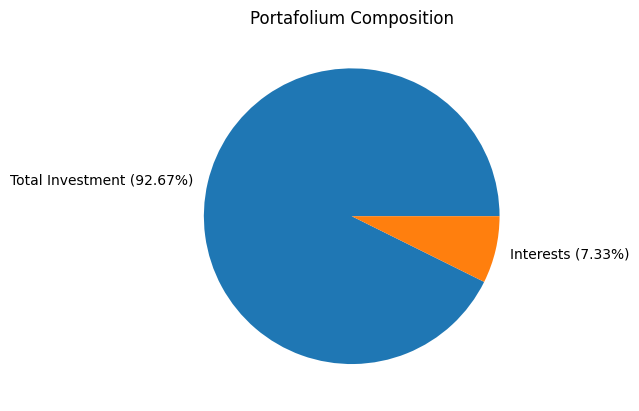

In [28]:
# Data for the pie chart
sizes = np.array([perc_total_invest, perc_total_gains])
labels = [f"Total Investment ({perc_total_invest:.2f}%)", f"Interests ({perc_total_gains:.2f}%)"]

# Create the pie chart
plt.pie(sizes, labels=labels)

# Add a title (optional)
plt.title("Portafolium Composition")

# Show the plot
plt.show()